In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# ==============================================================================
# 1. CHARGEMENT DES DONNÉES
# ==============================================================================
JOURS_DE_BOURSE = 252

try:
    df_rendements = pd.read_csv("data/returns_final.csv", index_col="Date", parse_dates=True)
except FileNotFoundError:
    df_rendements = pd.read_csv("returns_final.csv", index_col="Date", parse_dates=True)

mu = df_rendements.mean() * JOURS_DE_BOURSE
Sigma = df_rendements.cov() * JOURS_DE_BOURSE
nombre_actifs = len(mu)
print(f"Optimisation sur {nombre_actifs} actifs avec Descente de Gradient.")

Optimisation sur 196 actifs avec Descente de Gradient.


In [8]:
# ==============================================================================
# 2. FONCTIONS MATHÉMATIQUES (Le Cœur du Sujet)
# ==============================================================================

def calculer_objectif(poids, mu, Sigma, alpha):
    """Fonction à minimiser (Rendement vs Risque)"""
    rendement = np.dot(poids, mu)
    # Variance = w^T * Sigma * w
    variance = np.dot(poids.T, np.dot(Sigma, poids)) 
    
    # On minimise : alpha * (-Rendement) + (1-alpha) * Variance
    return alpha * (-rendement) + (1 - alpha) * variance

def calculer_gradient(poids, mu, Sigma, alpha):
    """
    Calcule la direction de la pente (le gradient).
    Dérivée de -Rendement (linéaire) = -mu
    Dérivée de Variance (quadratique) = 2 * Sigma * w
    """
    grad_rendement = -mu
    grad_variance = 2 * np.dot(Sigma, poids)
    
    return alpha * grad_rendement + (1 - alpha) * grad_variance

def projection_simplex(v):
    """
    Projection exacte sur le simplexe (Somme = 1, x >= 0).
    Algorithme de Duchi et al. (2008).
    C'est la méthode géométriquement correcte pour la descente de gradient.
    """
    n = len(v)
    # 1. On trie v en ordre décroissant
    u = np.sort(v)[::-1]
    
    # 2. On cherche le nombre d'éléments à garder strictement positifs (rho)
    cssv = np.cumsum(u)
    indices = np.arange(n) + 1
    cond = u - (cssv - 1) / indices > 0
    rho = indices[cond][-1]
    
    # 3. On calcule le seuil (theta)
    theta = (cssv[rho - 1] - 1) / rho
    
    # 4. On projette
    w = np.maximum(v - theta, 0)
    return w

In [9]:
# ==============================================================================
# 3. ALGORITHME DE DESCENTE DE GRADIENT (Fait main)
# ==============================================================================

def optimiser_par_gradient(mu, Sigma, alpha, n_iterations=500, learning_rate=0.01):
    # 1. Point de départ : portefeuille équilibré (1/N)
    poids = np.array([1/nombre_actifs] * nombre_actifs)
    
    # 2. Boucle d'apprentissage
    for i in range(n_iterations):
        # A. On calcule la direction (la pente)
        grad = calculer_gradient(poids, mu, Sigma, alpha)
        
        # B. On fait un pas dans la direction opposée (Descente)
        poids = poids - learning_rate * grad
        
        # C. Projection : On corrige les poids pour qu'ils restent réalistes (Somme=1, Positifs)
        poids = projection_simplex(poids)
        
        # (Optionnel) Réduire le learning rate petit à petit pour affiner la fin
        # learning_rate *= 0.995 
        
    return poids

Calcul en cours (cela peut prendre quelques secondes)...
Optimisation avec Warm Start en cours...


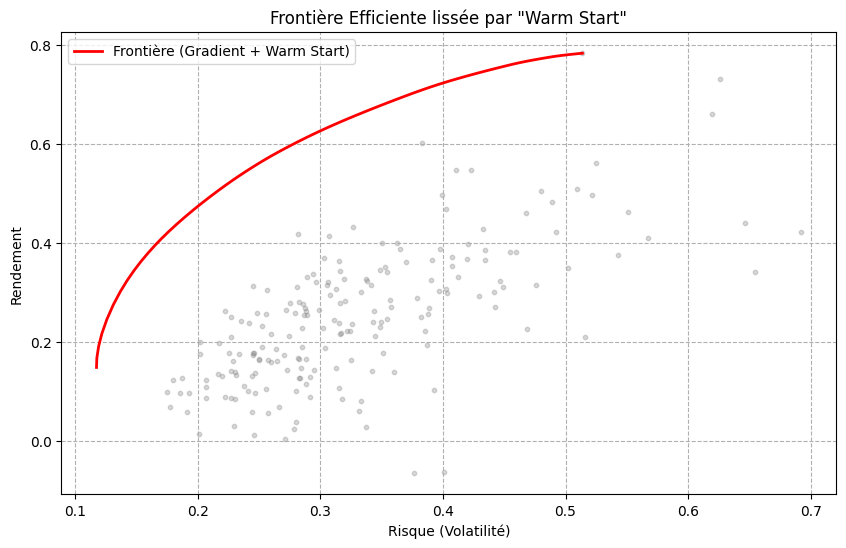

In [10]:
# ==============================================================================
# 4. EXÉCUTION ET VISUALISATION
# ==============================================================================
print("Calcul en cours (cela peut prendre quelques secondes)...")

alphas = np.linspace(0, 1, 50)
resultats_risque = []
resultats_rendement = []

# ==============================================================================
# VERSION AMÉLIORÉE : WARM START (Démarrage à chaud)
# ==============================================================================

# On augmente les itérations et on réduit le pas pour la précision
NB_ITERATIONS = 500 
TAUX_APPRENTISSAGE = 0.05 

alphas = np.linspace(0, 1, 100) # Plus de points pour une courbe lisse
resultats_risque = []
resultats_rendement = []

# ASTUCE : On garde les derniers poids en mémoire
# Point de départ initial : 1/N
poids_courants = np.array([1/nombre_actifs] * nombre_actifs)

print("Optimisation avec Warm Start en cours...")

for alpha in alphas:
    # On utilise 'poids_courants' comme point de départ (x0) au lieu de réinitialiser
    # Cela permet de "suivre" la courbe de proche en proche
    
    # --- Petite boucle d'optimisation locale ---
    for i in range(NB_ITERATIONS):
        grad = calculer_gradient(poids_courants, mu, Sigma, alpha)
        poids_courants = poids_courants - TAUX_APPRENTISSAGE * grad
        poids_courants = projection_simplex(poids_courants)
    # -------------------------------------------
    
    # On sauvegarde le résultat
    ret = np.dot(poids_courants, mu)
    risk = np.sqrt(np.dot(poids_courants.T, np.dot(Sigma, poids_courants)))
    
    resultats_rendement.append(ret)
    resultats_risque.append(risk)

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(resultats_risque, resultats_rendement, 'r-', linewidth=2, label='Frontière (Gradient + Warm Start)')

# Comparaison avec les actifs seuls
volatilite_actifs = np.sqrt(np.diag(Sigma))
plt.scatter(volatilite_actifs, mu, color='gray', s=10, alpha=0.3)

plt.title('Frontière Efficiente lissée par "Warm Start"')
plt.xlabel('Risque (Volatilité)')
plt.ylabel('Rendement')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()